In [2]:
import read_chroma
import mass_spec
import baseline_correction
import numpy as np
import peak_detection
import integration
import peaks_shape
import plot
from skimage.restoration import estimate_sigma
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Test Asym Gauss

In [8]:
def gauss_kernel(size: int, sizey: int=None, sigma=1.0) -> np.array:
    """
    Returns a 2D Gaussian kernel for convolutions.
    
    Parameters
    ----------
    size: int
        Size of the kernel to build
    
    Returns
    -------
    kernel: np.array of shape (size, size) and dtype np.float32
        Resulting Gaussian kernel where kernel[i,j] = Gaussian(i, j, mu=(0,0), sigma=(size/3, size/3))
    """
    if isinstance(sigma, tuple):
        sigma_y, sigma_x = sigma
    else:
        sigma_x=sigma
        sigma_y=sigma

    size = int(size)
    sizey = int(sizey) if sizey is not None else size
    y, x = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/(2*(sigma_x)**2)+y**2/(2*(sigma_y)**2)))
    return g
def asym_gauss_kernel(size: int, sizey: int=None, sigma=1.0) -> np.array:
    """
    Returns a 2D Gaussian kernel for convolutions.
    
    Parameters
    ----------
    size: int
        Size of the kernel to build
    
    Returns
    -------
    kernel: np.array of shape (size, size) and dtype np.float32
        Resulting Gaussian kernel where kernel[i,j] = Gaussian(i, j, mu=(0,0), sigma=(size/3, size/3))
    """
    if isinstance(sigma, tuple):
        sigma_y_1, sigma_y_2, sigma_x_1, sigma_x_2=sigma
    else:
        sigma_x_1=sigma
        sigma_x_2=sigma
        sigma_y_1=sigma
        sigma_y_2=sigma

    size = int(size)
    sizey = int(sizey) if sizey is not None else size
    y, x = np.mgrid[-size:size+1, -sizey:sizey+1]
    #g = np.exp(-(x**2/(2*(sigma_x)**2)+y**2/(2*(sigma_y)**2)))
    g=np.zeros_like((x)).astype(float)
    print(g.shape)
    for i in range(len(x)):
        for j in range(len(x)):
            sigma_x=sigma_x_1 if x[i][j] >= 0 else sigma_x_2
            sigma_y=sigma_y_1 if y[i][j] >= 0 else sigma_y_2
            g[i][j]=np.exp(-(x[i][j]**2/(2*(sigma_x)**2)+y[i][j]**2/(2*(sigma_y)**2)))

    return g

(161, 161)


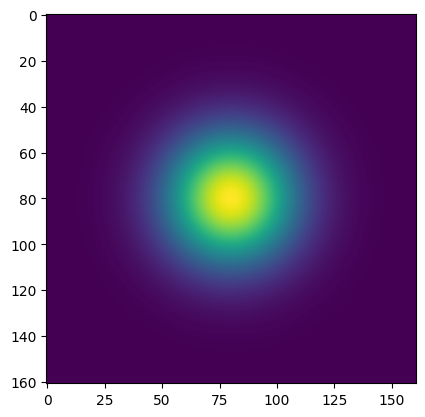

In [9]:
g_asym=asym_gauss_kernel(80, sigma=(20,20,20,20))
plt.imshow(g_asym)

# Peak charac

In [10]:
from pympler.asizeof import asizeof

In [3]:
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('estimate_sigma', 136),
 ('open', 136),
 ('regionprops', 136),
 ('np', 72),
 ('plt', 72)]

In [4]:
chromato_obj=read_chroma.read_chroma(filename='F:/Bureau/032023-data-Tenax-VOC-COVID/801850-A-C-01-157-split10.cdf')

In [5]:
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('estimate_sigma', 136),
 ('open', 136),
 ('regionprops', 136),
 ('np', 72),
 ('plt', 72),
 ('chromato_obj', 64)]

In [13]:
print(asizeof(chromato_obj[0]),asizeof(chromato_obj[2]))
print(asizeof(chromato_obj))

4320408 2141785976
2146106552


+2 GO

In [14]:
mod_time = 1.25
chromato,time_rn,spectra_obj = chromato_obj
full_spectra = mass_spec.read_full_spectra_centroid(spectra_obj=spectra_obj)

--- 308.8048474788666 seconds --- to compute full spectra centroid


In [18]:
print(asizeof(full_spectra[0]), asizeof(full_spectra[1]), asizeof(full_spectra[2]))
print(asizeof(full_spectra))

3603113680 4320408 4320408
3611754528


+3,6 GO

In [19]:
spectra, debuts, fins = full_spectra
chromato_cube = read_chroma.full_spectra_to_chromato_cube(full_spectra=full_spectra, spectra_obj=spectra_obj)

In [30]:
print(asizeof(spectra)), print(asizeof(chromato_cube)), print(asizeof(spectra)/asizeof(chromato_cube))

3603113680
1801440160
2.0001295408002893


(None, None, None)

Chromato cube plus leger que les spectres. Lorsque l'on construit les chromato on coupe une partie "chromato_mass_tm = np.reshape(chromato_mass[:l1*l2], (l2,l1))" Est ce que ça vient de la ?
Non c'est parce que l'on ne stock plus les masses on divise donc la taille par 2.

In [33]:
chromato = baseline_correction.chromato_no_baseline(chromato)
chromato_cube = np.array(baseline_correction.chromato_cube_corrected_baseline(chromato_cube))

In [34]:
seuil=5

In [43]:
sigma = estimate_sigma(chromato, channel_axis=None)
MIN_SEUIL = seuil * sigma * 100 / np.max(chromato)
# find 2D peaks
coordinates = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, None)
len(coordinates)

In [21]:
THRESHOLD=0.60

# Binary peaks

In [121]:
rotation_moments=[]
peaks_dim=[]
peaks_int=[]
areas=[]
x_center_of_gravity=[]
y_center_of_gravity=[]
blobs=[]
nb_skipped_peak=0
for peak_cd in coordinates[:20]:
    blob=integration.peak_pool(chromato, coordinates, peak_cd, threshold=THRESHOLD)
    cds=np.argwhere(blob == 1)
    x_min=np.min(cds[:,0])
    x_max=np.max(cds[:,0])
    y_min=np.min(cds[:,1])
    y_max=np.max(cds[:,1])
    binary_img=blob[x_min:x_max, y_min:y_max]
    width=binary_img.shape[0]
    height=binary_img.shape[1]

    if (x_min==x_max or y_min==y_max):
        '''print(peak_cd)
        print(x_min, x_max, y_min,y_max)'''
        nb_skipped_peak+=1
        continue
    blobs.append(binary_img)
    area=peaks_shape.calculate_moment(binary_img, width, height, 0, 0)
    areas.append(area)
    x_center, y_center=peaks_shape.centre_of_gravity(binary_img, width, height)
    x_center_of_gravity.append(x_center)
    y_center_of_gravity.append(y_center)
    rotation_moment=peaks_shape.rotation_moment(binary_img, width, height)
    rotation_moments.append(rotation_moment)
    peaks_dim.append([x_max-x_min, y_max-y_min])
    peaks_int.append(chromato[peak_cd[0], peak_cd[1]])

blobs=np.array(blobs)
areas=np.array(areas)
x_center_of_gravity=np.array(x_center_of_gravity)
y_center_of_gravity=np.array(y_center_of_gravity)
rotation_moments=np.array(rotation_moments)
peaks_dim=np.array(peaks_dim)
peaks_int=np.array(peaks_int)

C:\Users\Stan\AppData\Local\Temp\ipykernel_5920\558958030.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  blobs=np.array(blobs)


Area

In [122]:
np.mean(areas), np.std(areas), np.median(areas), np.std(areas) / np.mean(areas)

(24.25, 27.110652887748756, 17.5, 1.117965067536031)

Centers of gravity

In [123]:
np.mean(x_center_of_gravity), np.std(x_center_of_gravity), np.median(x_center_of_gravity), np.std(x_center_of_gravity) / np.mean(x_center_of_gravity)

(0.7483449461289218,
 0.5972720548308743,
 0.6092436974789917,
 0.7981239907083956)

In [124]:
np.mean(y_center_of_gravity), np.std(y_center_of_gravity), np.median(y_center_of_gravity), np.std(y_center_of_gravity) / np.mean(y_center_of_gravity)

(6.4258195776502065, 8.177572298753654, 4.019230769230769, 1.2726115633866004)

Rotation invariants moments

In [125]:
np.mean(rotation_moments, axis=0), np.std(rotation_moments, axis=0), np.median(rotation_moments, axis=0), np.std(rotation_moments, axis=0) / np.mean(rotation_moments, axis=0)

(array([ 6.24702994e-01,  7.86682473e-01,  2.18438657e-02,  1.99911977e-02,
         6.04987194e-03,  5.35667672e-02, -5.20016692e-06]),
 array([6.43687686e-01, 2.00323737e+00, 7.61051638e-02, 7.47208207e-02,
        2.59564558e-02, 2.26339607e-01, 2.21869272e-05]),
 array([4.51354673e-01, 1.81077582e-01, 8.78348263e-04, 1.16177731e-04,
        2.90945498e-08, 1.18428711e-05, 0.00000000e+00]),
 array([ 1.03038995,  2.54643702,  3.48405199,  3.73768604,  4.29041408,
         4.22537365, -4.26657981]))

Peaks dims

In [126]:
np.mean(peaks_dim, axis=0), np.std(peaks_dim, axis=0), np.median(peaks_dim, axis=0), np.std(peaks_dim, axis=0) / np.mean(peaks_dim, axis=0)

(array([ 2.3 , 13.35]),
 array([ 1.05356538, 15.04418492]),
 array([ 2., 10.]),
 array([0.4580719 , 1.12690524]))

Intensities

In [127]:
np.mean(peaks_int, axis=0), np.std(peaks_int, axis=0), np.median(peaks_int, axis=0)

(144425191.43240494, 22399782.42467879, 149212887.10442716)

# Peak with intensities

In [128]:
int_rotation_moments=[]
int_peaks_dim=[]
int_peaks_int=[]
int_areas=[]
int_x_center_of_gravity=[]
int_y_center_of_gravity=[]
int_blobs=[]
nb_skipped_peak=0
for peak_cd in coordinates[:]:
    blob=integration.peak_pool(chromato, coordinates, peak_cd, threshold=THRESHOLD)
    cds=np.argwhere(blob == 1)
    x_min=np.min(cds[:,0])
    x_max=np.max(cds[:,0])
    y_min=np.min(cds[:,1])
    y_max=np.max(cds[:,1])
    binary_img=chromato[x_min:x_max, y_min:y_max]
    width=binary_img.shape[0]
    height=binary_img.shape[1]
    int_blobs.append(binary_img)
    if (x_min==x_max or y_min==y_max):
        nb_skipped_peak+=1
        continue
    area=peaks_shape.calculate_moment(binary_img, width, height, 0, 0)
    int_areas.append(area)
    x_center, y_center=peaks_shape.centre_of_gravity(binary_img, width, height)
    int_x_center_of_gravity.append(x_center)
    int_y_center_of_gravity.append(y_center)
    rotation_moment=peaks_shape.rotation_moment(binary_img, width, height)
    int_rotation_moments.append(rotation_moment)
    int_peaks_dim.append([x_max-x_min, y_max-y_min])
    int_peaks_int.append(chromato[peak_cd[0], peak_cd[1]])

int_blobs=np.array(int_blobs)
int_areas=np.array(int_areas)
int_x_center_of_gravity=np.array(int_x_center_of_gravity)
int_y_center_of_gravity=np.array(int_y_center_of_gravity)
int_rotation_moments=np.array(int_rotation_moments)
int_peaks_dim=np.array(int_peaks_dim)
int_peaks_int=np.array(int_peaks_int)

C:\Users\Stan\AppData\Local\Temp\ipykernel_5920\3428356990.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  int_blobs=np.array(int_blobs)


Area

In [129]:
np.mean(int_areas), np.std(int_areas), np.median(int_areas), np.std(int_areas) / np.mean(int_areas)

(516279974.1157139, 1241822756.1010602, 118342331.61796775, 2.4053281520904592)

Center of gravity

In [130]:
np.mean(int_x_center_of_gravity), np.std(int_x_center_of_gravity), np.median(int_x_center_of_gravity), np.std(int_x_center_of_gravity) / np.mean(int_x_center_of_gravity)

(0.8948127497541941, 1.3347126205345492, 0.4947375258582583, 1.49161108947229)

In [131]:
np.mean(int_y_center_of_gravity), np.std(int_y_center_of_gravity), np.median(int_y_center_of_gravity), np.std(int_y_center_of_gravity) / np.mean(int_y_center_of_gravity)

(3.675601840459437, 3.886439812841342, 2.511604734888791, 1.0573614829716025)

Rotation invariants moments

In [132]:
np.mean(int_rotation_moments, axis=0), np.std(int_rotation_moments, axis=0), np.median(int_rotation_moments, axis=0), np.std(int_rotation_moments, axis=0) / np.mean(int_rotation_moments, axis=0)

(array([5.36897344e-08, 7.18380561e-15, 8.97120339e-24, 8.95307744e-24,
        2.37855726e-44, 5.18453731e-30, 3.97228158e-50]),
 array([6.75493491e-08, 2.87469623e-14, 1.53971363e-22, 1.53963540e-22,
        7.41854740e-43, 1.31975337e-28, 2.70387066e-48]),
 array([2.87225977e-08, 5.78990543e-16, 1.42715551e-26, 1.42715551e-26,
        1.52976491e-52, 2.65652989e-34, 0.00000000e+00]),
 array([ 1.25814273,  4.00163421, 17.16284387, 17.19671715, 31.18927393,
        25.45556704, 68.06845384]))

# Binary Peak Vs Full Peak

# Area

In [133]:
np.mean(areas), np.std(areas), np.median(areas), np.std(areas) / np.mean(areas)

(24.25, 27.110652887748756, 17.5, 1.117965067536031)

In [134]:
np.mean(int_areas), np.std(int_areas), np.median(int_areas), np.std(int_areas) / np.mean(int_areas)

(516279974.1157139, 1241822756.1010602, 118342331.61796775, 2.4053281520904592)

Center of gravity

In [135]:
np.mean(x_center_of_gravity), np.std(x_center_of_gravity), np.median(x_center_of_gravity), np.std(x_center_of_gravity) / np.mean(x_center_of_gravity)

(0.7483449461289218,
 0.5972720548308743,
 0.6092436974789917,
 0.7981239907083956)

In [136]:
np.mean(y_center_of_gravity), np.std(y_center_of_gravity), np.median(y_center_of_gravity), np.std(y_center_of_gravity) / np.mean(y_center_of_gravity)

(6.4258195776502065, 8.177572298753654, 4.019230769230769, 1.2726115633866004)

In [137]:
np.mean(int_x_center_of_gravity), np.std(int_x_center_of_gravity), np.median(int_x_center_of_gravity), np.std(int_x_center_of_gravity) / np.mean(int_x_center_of_gravity)

(0.8948127497541941, 1.3347126205345492, 0.4947375258582583, 1.49161108947229)

In [138]:
np.mean(int_y_center_of_gravity), np.std(int_y_center_of_gravity), np.median(int_y_center_of_gravity), np.std(int_y_center_of_gravity) / np.mean(int_y_center_of_gravity)

(3.675601840459437, 3.886439812841342, 2.511604734888791, 1.0573614829716025)

Rotation invariants momemts

In [139]:
np.mean(rotation_moments, axis=0), np.std(rotation_moments, axis=0), np.median(rotation_moments, axis=0), np.std(rotation_moments, axis=0) / np.mean(rotation_moments, axis=0)

(array([ 6.24702994e-01,  7.86682473e-01,  2.18438657e-02,  1.99911977e-02,
         6.04987194e-03,  5.35667672e-02, -5.20016692e-06]),
 array([6.43687686e-01, 2.00323737e+00, 7.61051638e-02, 7.47208207e-02,
        2.59564558e-02, 2.26339607e-01, 2.21869272e-05]),
 array([4.51354673e-01, 1.81077582e-01, 8.78348263e-04, 1.16177731e-04,
        2.90945498e-08, 1.18428711e-05, 0.00000000e+00]),
 array([ 1.03038995,  2.54643702,  3.48405199,  3.73768604,  4.29041408,
         4.22537365, -4.26657981]))

In [140]:
np.mean(int_rotation_moments, axis=0), np.std(int_rotation_moments, axis=0), np.median(int_rotation_moments, axis=0), np.std(int_rotation_moments, axis=0) / np.mean(int_rotation_moments, axis=0)

(array([5.36897344e-08, 7.18380561e-15, 8.97120339e-24, 8.95307744e-24,
        2.37855726e-44, 5.18453731e-30, 3.97228158e-50]),
 array([6.75493491e-08, 2.87469623e-14, 1.53971363e-22, 1.53963540e-22,
        7.41854740e-43, 1.31975337e-28, 2.70387066e-48]),
 array([2.87225977e-08, 5.78990543e-16, 1.42715551e-26, 1.42715551e-26,
        1.52976491e-52, 2.65652989e-34, 0.00000000e+00]),
 array([ 1.25814273,  4.00163421, 17.16284387, 17.19671715, 31.18927393,
        25.45556704, 68.06845384]))

Peaks dims

In [141]:
np.mean(peaks_dim, axis=0), np.std(peaks_dim, axis=0), np.median(peaks_dim, axis=0), np.std(peaks_dim, axis=0) / np.mean(peaks_dim, axis=0)

(array([ 2.3 , 13.35]),
 array([ 1.05356538, 15.04418492]),
 array([ 2., 10.]),
 array([0.4580719 , 1.12690524]))

Intensities

In [142]:
np.mean(peaks_int, axis=0), np.std(peaks_int, axis=0), np.median(peaks_int, axis=0), np.std(peaks_int, axis=0) / np.mean(peaks_int, axis=0)

(144425191.43240494,
 22399782.42467879,
 149212887.10442716,
 0.15509608955694215)

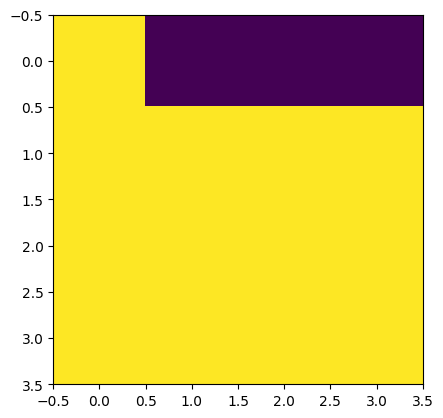

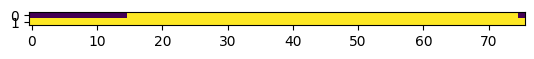

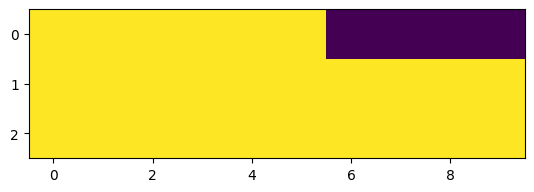

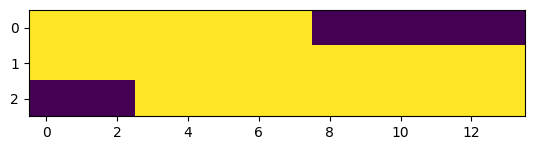

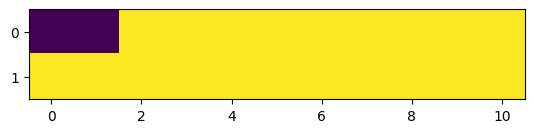

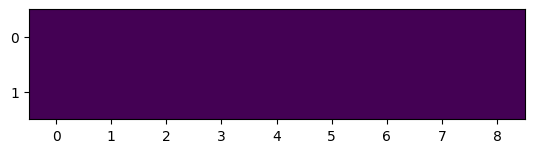

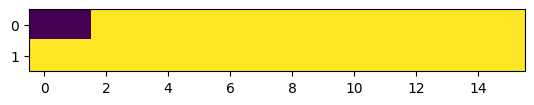

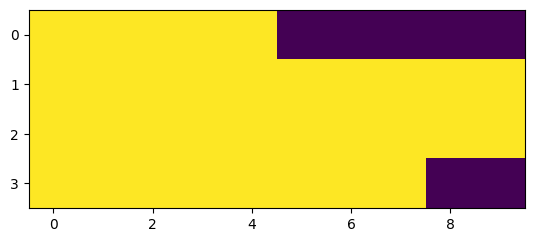

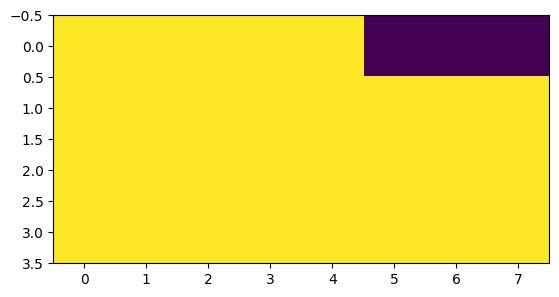

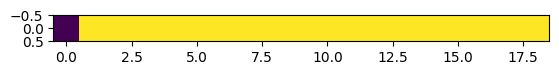

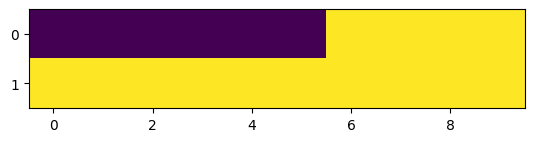

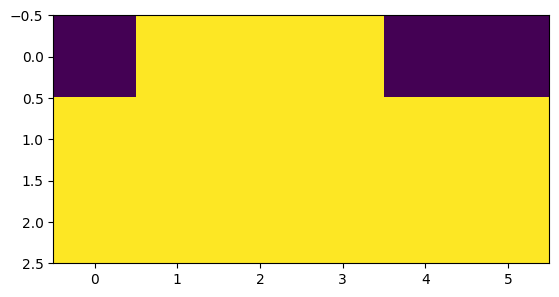

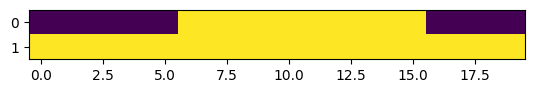

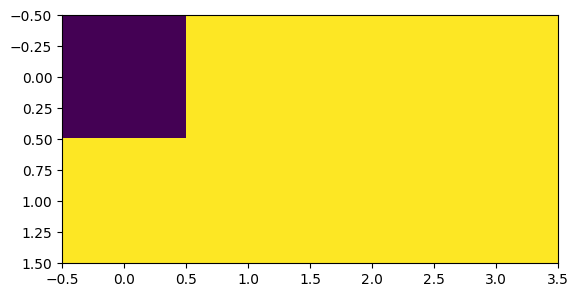

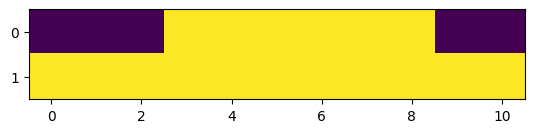

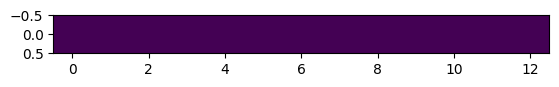

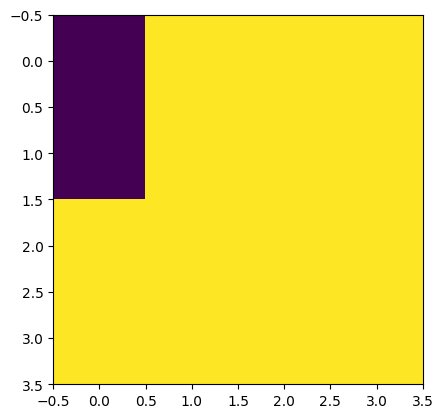

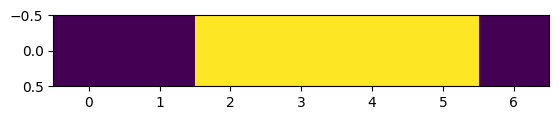

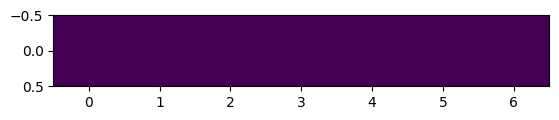

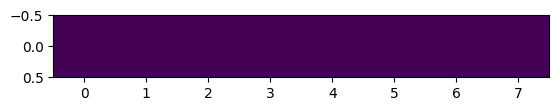

In [145]:
nb_blobs=20
for i, blob in enumerate(blobs[:nb_blobs]):
    plt.imshow(blob)
    plt.show()

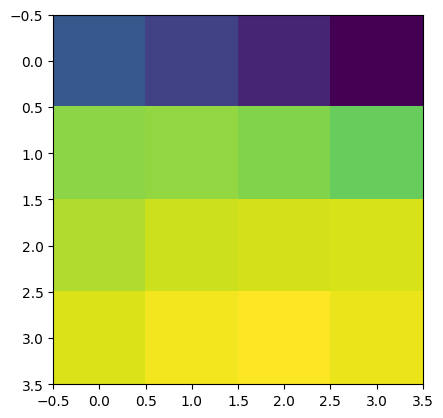

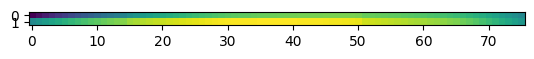

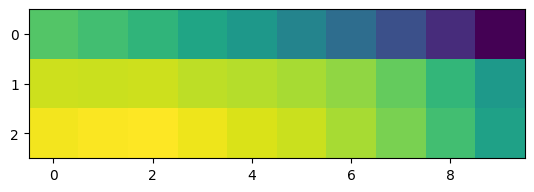

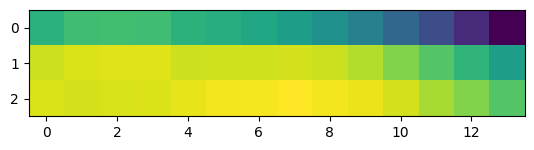

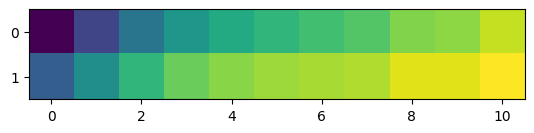

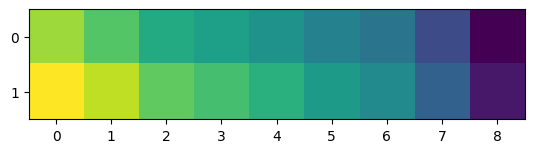

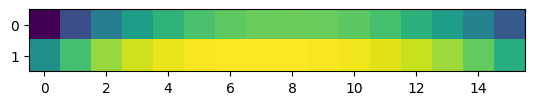

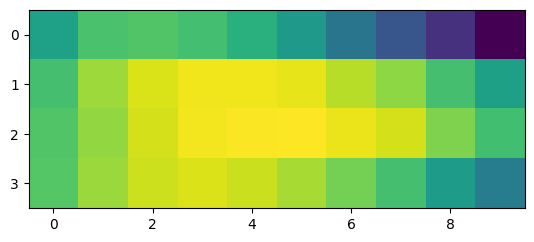

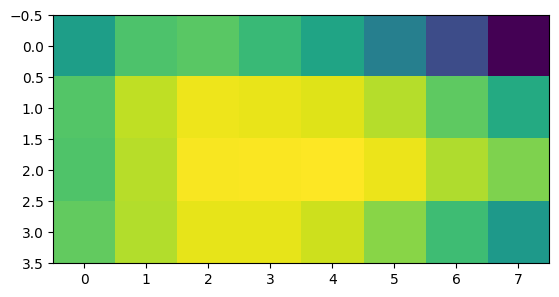

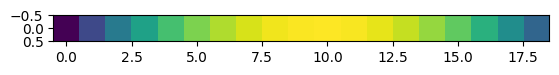

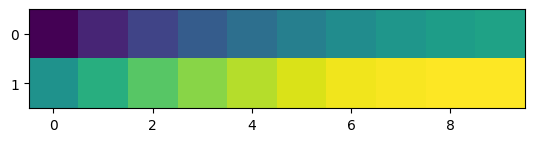

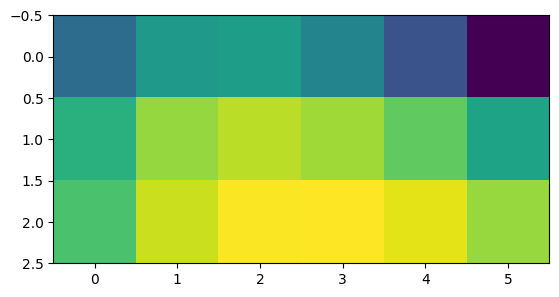

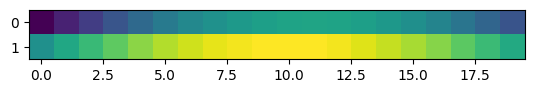

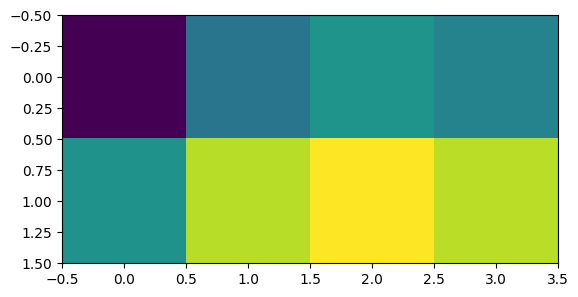

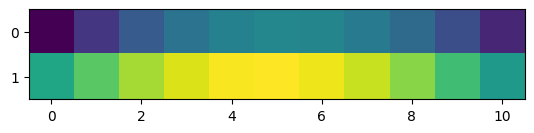

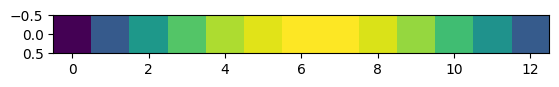

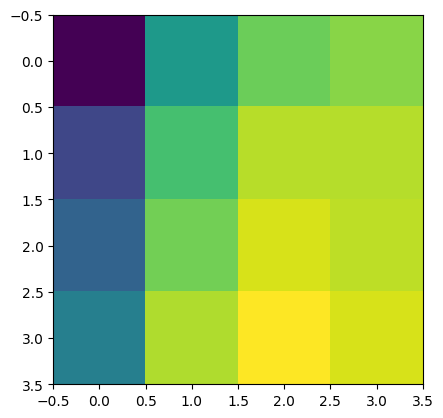

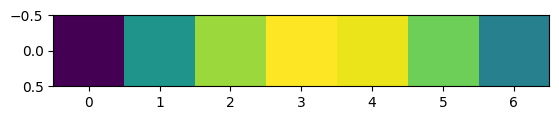

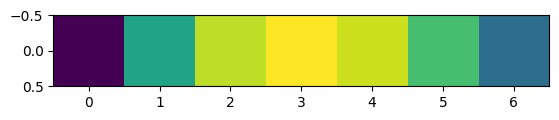

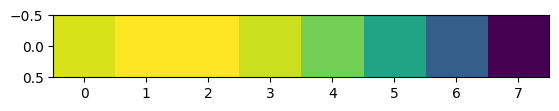

In [146]:
nb_blobs=20
for i, blob in enumerate(blobs[:nb_blobs]):
    plt.imshow(int_blobs[i])
    plt.show()

# Metrics

In [24]:
int_peaks_dim=[]
nb_skipped_peak=0

int_areas=[]
perimeters=[]
int_x_center_of_gravity=[]
int_y_center_of_gravity=[]
weighted_int_x_center_of_gravity=[]
weighted_int_y_center_of_gravity=[]
intensites_min=[]
intensites_max=[]
intensites_mean=[]
moments=[]
moments_central=[]
moments_hu=[]
weighted_moments=[]
weighted_moments_central=[]
weighted_moments_hu=[]
l1s=[]
l2s=[]
orientations=[]
int_blobs=[]
areas=[]

for peak_cd in coordinates[:]:
    blob=integration.peak_pool(chromato, coordinates, peak_cd, threshold=THRESHOLD)
    cds=np.argwhere(blob == 1)
    x_min=np.min(cds[:,0])
    x_max=np.max(cds[:,0])
    y_min=np.min(cds[:,1])
    y_max=np.max(cds[:,1])
    binary_img=blob[x_min:x_max, y_min:y_max]
    intensity_img=chromato[x_min:x_max, y_min:y_max]
    width=binary_img.shape[0]
    height=binary_img.shape[1]
    int_blobs.append(binary_img)
    if (x_min==x_max or y_min==y_max):
        nb_skipped_peak+=1
        continue
    try:    
        props=regionprops(binary_img, intensity_img)[0]
    except:
        plt.imshow(binary_img)
        print(x_min,x_max,  y_min,y_max)
        print(props)

    areas.append(props.area)
    perimeters.append(props.perimeter)

    axis_minor_length=props.axis_minor_length
    axis_major_length=props.axis_major_length

    centroid=props.centroid
    int_x_center_of_gravity.append(centroid[0])
    int_y_center_of_gravity.append(centroid[1])

    weighted_centroid=props.centroid_weighted
    weighted_int_x_center_of_gravity.append(centroid[0])
    weighted_int_y_center_of_gravity.append(centroid[1])

    intensites_min.append(props.intensity_min)
    intensites_max.append(props.intensity_max)
    intensites_mean.append(props.intensity_mean)

    moments.append(props.moments)
    moments_central.append(props.moments_central)
    moments_hu.append(props.moments_hu)

    weighted_moments.append(props.moments_weighted)
    weighted_moments_central.append(props.moments_weighted_central)
    weighted_moments_hu.append(props.moments_weighted_hu)

    orientations.append(props.orientation)

    l1 = props.inertia_tensor_eigvals[0]
    l2 = props.inertia_tensor_eigvals[-1]
    l1s.append(4 * np.sqrt(l1))
    l2s.append(4 * np.sqrt(l2))

orientations=np.array(orientations)

moments=np.array(moments)
moments_central=np.array(moments_central)
moments_hu=np.array(moments_hu)

weighted_moments=np.array(weighted_moments)
weighted_moments_central=np.array(weighted_moments_central)
weighted_moments_hu=np.array(weighted_moments_hu)

int_x_center_of_gravity=np.array(int_x_center_of_gravity)
int_y_center_of_gravity=np.array(int_y_center_of_gravity)

weighted_int_x_center_of_gravity=np.array(weighted_int_x_center_of_gravity)
weighted_int_y_center_of_gravity=np.array(weighted_int_y_center_of_gravity)

intensites_min=np.array(intensites_min)
intensites_max=np.array(intensites_max)
intensites_mean=np.array(intensites_mean)

areas=np.array(areas)
perimeters=np.array(perimeters)

l1s=np.array(l1s)
l2s=np.array(l2s)
int_blobs=np.array(int_blobs)
int_areas=np.array(int_areas)
int_x_center_of_gravity=np.array(int_x_center_of_gravity)
int_y_center_of_gravity=np.array(int_y_center_of_gravity)

int_peaks_dim=np.array(int_peaks_dim)

orientations=np.array(orientations)

C:\Users\Stan\AppData\Local\Temp\ipykernel_11996\2594881694.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  int_blobs=np.array(int_blobs)
